In [190]:
import math
def General_distance(length):
    distance = []
    for i in range(1, length):
        local_distance = math.factorial(length) * (20 ** (length - i)) * ((20 * 19) ** i) / (math.factorial(length - i) * math.factorial(i))
        distance.append(local_distance / 2)
    distance.append((20*19) ** length /2 )
    return distance 

In [191]:
gen_distances = General_distance(100)
sum(gen_distances)


8.034690221294951e+259

In [188]:
20 ** 100 * (20 ** 100 - 1) 

160693804425899027554196209234116260252220299378279283530137599999999999999999999999999999999999999999999999999999999999999999999987323493997717705985032967946240000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

1383200.0
16598400.0
182582400.0
1825824000.0
16432416000.0
131459328000.0
920215296000.0
5521291776000.0
27606458880000.0
110425835520000.0
331277506560000.0
662555013120000.0
662555013120000.0


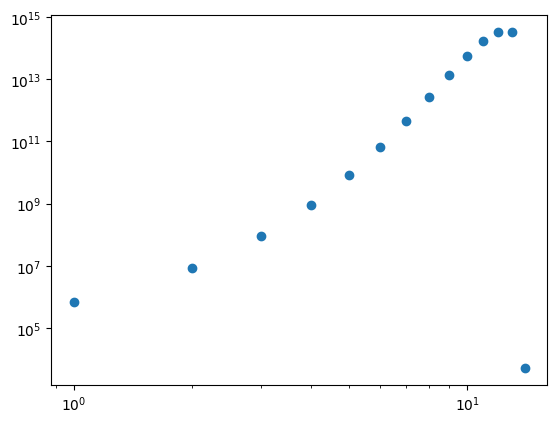

In [121]:
import matplotlib.pyplot as plt
plt.scatter(range(1, 15), General_distance(14))
plt.xscale('log')
plt.yscale('log')

In [233]:
#importing modules
import argparse
import pandas as pd
import re
import os
import numpy as np
import itertools
from scipy import stats
import ast
#from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

def t_student_one_sided(sample_size, p=0.05):
    # One-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(stats.t.ppf(p, df))
    return(tinv(p, sample_size-2)) # Returns: The critical value from the one-sided t-distribution.

# def matrix_to_array(matrix, nparray=False, in_folder='', from_file = False):
#     """
#     Function to convert the upper triangular matrix into a 1-dimensional array with matrix values (from upper half of the input matrix) 
#     Possible input file format examples:
#     when nparray==False:
#     Square matrix in csv format (either upper triangular or symmetric but NOT lower triangular):
#     0,1,2
#     0,0,3
#     0,0,0
    
#     when nparray==True:
#     Square matrix in np.array format (either upper triangular or symmetric but NOT lower triangular):
#     array([[0, 1, 2],
#            [1, 0, 3],
#            [2, 3, 0]]))
#     """
#     #first, we open an input matrix in n-dimensional numpy array format, for example:
#     #    array([[0, 1, 2],
#     #           [0, 0, 3],
#     #           [0, 0, 0]]))
    
#     if from_file==True:
#         if nparray==True: #if input file is a np.array in a txt file (nparray variable should be set to True) 
#             pdist=np.array(ast.literal_eval(open(in_folder+matrix).read()))
#         else: #if input file is a csv
#             pdist=pd.read_csv(in_folder+matrix, header=None).to_numpy()
#             return(list(pdist[np.triu_indices(np.shape(pdist)[0], k = 1)]), len(pdist))

    #return only the elements above diagonal with np.triu_indices function as a 1d array given the matrix dimension (number of rows/columns)    
    # else:
    #     return(list(matrix[np.triu_indices(np.shape(matrix)[0], k = 1)]), len(matrix))

# Функція для побудови графіка залежності кількості пар на заданій відстані від самої відстані

def get_curves_LD_all_kcoefs_ranges(k, log=False, norm=False,  numbins=100, nparray=False, in_folder='', from_file=False, flat=False):
    """Function to plot the number of pairs at a given distance against the distance"""
    
    #read pairwise distance matrix as an 1d array
    # if flat==True:
    #     k, size= matrix
    # else:
    #     k,size=squareform(matrix, nparray=nparray, in_folder=in_folder, from_file=from_file)
    size = len(k)
    #creates a histogram of the distances
    if log==True:
        # using logspace so that the points appear to be equally spaced in the log scale
        binn=np.histogram(k, bins=list(np.append(np.zeros(1), np.logspace(-2.99573227,0,numbins,base=math.e))))
    else:
        binn=np.histogram(k, bins=list(np.linspace(0,1, numbins+1)))
    #get x axis (range of pairwise distances)
    dista=np.log(binn[1][1:])
    #get y axis (cumulative pairs counts)
    cumulative=np.cumsum(binn[0])
    
    #check if there are any empty bins at small distances
    #if there are any, these bins will be excluded (because np.log(0)=-inf which is a problem during dimension calculation)
    if 0 in cumulative:
        last0_ind=np.where(cumulative==0)[0][-1]+1
        cumulative=cumulative[last0_ind:]
        dista=dista[last0_ind:]
    #normalize y scale or not: DOES NOT alter dimension value in the end, only usefull for visualization purposes
    if norm==True:
        # applying the Normalization: log(E)/N^2
        return(dista, np.log(cumulative/size**2))
    else:
        return(dista, np.log(cumulative))
    
def max_k(matrix, log=False, win_size_perc=0.05, numbins = 100, t_stud=None, mode='max', norm=False, plot=False, in_folder='', out_folder='',out_plots='',nparray=False,from_file=True,save_picture=False, flat=False, label=''):
    
    """
    Function to calculate dimension from the matrix of pairwise distances.
    Supports three modes of calculation: 
    - MODE="max": dimension is the highest slope of the linear regression slopes done on all windows of size WIN_SIZE_PERC*NUMBINS
    - MODE="min_max": same as "max" mode + it gives a min_k value - the slope of the curve from 0% sequence distance to (but not including) the 
      first point included in region used to calculate max_k
    - MODE="min_max_50": function outputs the "max" and "min" dimension values and "0-50%" dimension 
      (the slope of the linear regression done on the first WIN_SIZE_PERC*NUMBINS (0-WIN_SIZE_PERC% divergence))
    """
    #get the file name prefix 
    # if flat==False:
    #     fn=re.findall('(.+)\.', matrix)[0]
    # else:
    #     fn='simulated_matrix'
    
    #get x and y for regression, where
    #x - pairwise distance in log scale (0-100% divergence)
    #y - log of number of pairs per bin at a a given pairwise distance
    (x, y)= matrix

    slopes = []
    x_range = []
    rvals= []
    sterrs = []
    bs = []
    
    win_size=int(win_size_perc*numbins)
    length=len(x)
        #to find maximun slope check all intervals of the curve of length WIN_SIZE
    for i in range(len(x)-win_size+1):
        win_x=x[i:i+win_size]
        win_y=y[i:i+win_size]
        slope, b, r_value, p_value, std_err =  stats.linregress(win_x, win_y)
        #record only positive slopes
        if slope <= 0:
            continue
        slopes.append(slope)
        rvals.append(r_value)
        x_range.append(win_x)
        bs.append(b)
        sterrs.append(std_err)
        
    if len(slopes) == 0:
        raise ValueError(
            """
            No positive slopes or no windows
            with all values above threshold found!
            """
            )

    max_k = max(slopes)
    ind=slopes.index(max_k)
    max_x = x_range[ind]
    max_r = rvals[ind]
    max_b = bs[ind]
    
        
    #adjustment in case the actual length of the x axis is different from numbins (empty bins removed in get_curves_LD_all_kcoefs_ranges function)
    difflen=numbins-length    

    #get the range of the distances used to get the highest slope
    if log==True:
        x_coor_nolog=list(np.append(np.zeros(1), np.logspace(-2.99573227,0,numbins,base=math.e)))[difflen:]
        log_str='log'
    else:
        x_coor_nolog=list(np.linspace(0,1, numbins+1))[difflen:]
        log_str='non_log'

    range_start=x_coor_nolog[ind]
    range_end=x_coor_nolog[ind+win_size]

        
    #calculate confidence interval for the slope
    #one sided T Student test is performed because our curve is cumulative, therefore slope will be > 0
    if t_stud!=None and difflen==0:
        #use precalculated t_student value
        max_ci=t_stud*sterrs[ind]
    else:
        t_stud=t_student_one_sided(win_size)
        max_ci=t_stud*sterrs[ind]
    
    
    #saving plot    
    if plot ==True and flat==False:
        plt.scatter(x, y, label= label)
        #plot max slope
        plt.plot(max_x, max_k*max_x + max_b, label="{:.2f}-{:.2f}, y={:.2f}x+{:.2f}\nR^2={:.3f}, 95% CI={:.3f}".format(range_start, range_end, max_k, max_b,max_r**2, max_ci), c='r')
        plt.legend(loc='lower right', prop={'size': 9}) # move the legend 
        plt.ylabel('log(N)')
        plt.xlabel('log(Pairwise distance)')
        plt.show()
        if save_picture==True:        
            plt.savefig(out_plots+'%s_%s_%s_%s.png' % (fn, log_str, str(win_size_perc), str(numbins)))
    return(max_k, max_ci)   



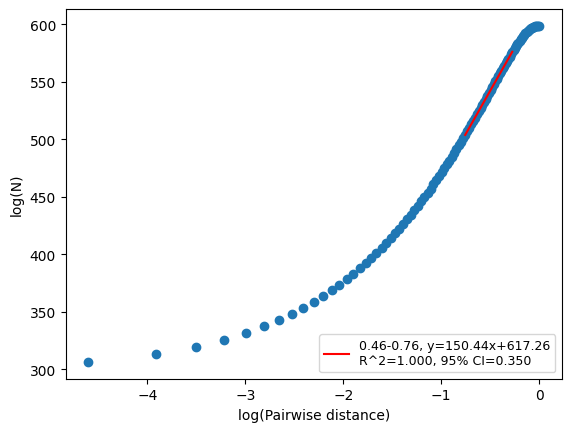

(150.43542470732797, 0.3503122025627339)

In [230]:
import numpy as np
gen_distances = np.cumsum(General_distance(100))
gen_distances = np.log(gen_distances)
dist_range = np.array(range(1, 101))
dist_range = dist_range/100
dist_range = np.log(dist_range)
max_k((dist_range, gen_distances), plot = True)

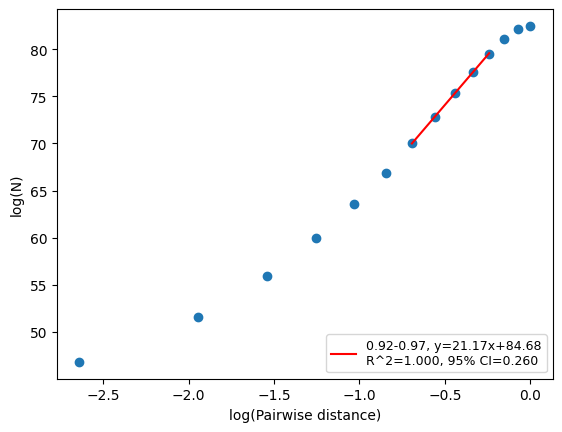

(21.174944421562955, 0.26018125314662527)

In [234]:
import numpy as np
gen_distances = np.array(General_distance(14))
gen_distances = np.log(gen_distances)
dist_range = np.array(range(1, 15))
dist_range = dist_range/14
dist_range = np.log(dist_range)
max_k((dist_range, gen_distances), plot = True)

In [56]:
dist_range = np.array(range(1, 15))
dist_range = dist_range/14
dist_range = np.log(dist_range)
dist_range

array([-2.63905733, -1.94591015, -1.54044504, -1.25276297, -1.02961942,
       -0.84729786, -0.69314718, -0.55961579, -0.44183275, -0.33647224,
       -0.24116206, -0.15415068, -0.07410797,  0.        ])